# Google Colab Settings - skip if not relevant

In [1]:
# google colab/ drive settings
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/other/ct-segmentation-monai


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/other/ct-segmentation-monai


In [2]:
!uv pip install --system -e .

Using Python 3.12.12 environment at: /usr
Resolved 56 packages in 65ms
Prepared 1 package in 872ms
Uninstalled 1 package in 0.59ms
Installed 1 package in 0.89ms
 ~ ct-segmentation-monai==0.1.0 (from file:///content/drive/MyDrive/other/ct-segmentation-monai)


# Imports

In [6]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from monai.data import DataLoader, Dataset, CacheDataset, DataLoader, decollate_batch
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.utils import one_hot
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    EnsureTyped,
    AsDiscrete
)
from monai.inferers import SlidingWindowInferer
import sys
import os
from pathlib import Path
import torch
import glob
import time
import datetime
import subprocess
import shutil


<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


In [7]:
root_dir = Path(os.getcwd()).parent
sys.path.append(str(root_dir))
print(root_dir)

from src.data.transform import get_train_transforms, get_val_transforms
from src.models.unet import get_unet_model
from src.training.train import train_one_epoch, validate_one_epoch
from src.utils.plotting import plot_loss_metrics, plot_segmentation_predictions

/content/drive/MyDrive/other


**ATTENTION**: next cell only relevant if google colab is used

In [8]:
source_dir = "/content/drive/MyDrive/other/ct-segmentation-monai/data/raw/Task07_Pancreas"
local_dir = "/content/data/Task07_Pancreas"
remove_if_exists=False

if not os.path.exists(local_dir):
    print("for efficiency: copy data to local vm")
    shutil.copytree(source_dir, local_dir)
    print("done")
elif remove_if_exists:
    # remove folder
    print("data already there - removing data")
    shutil.rmtree(local_dir)
    # recreate
    shutil.copytree(source_dir, local_dir)
    print("data copied")
else:
    print("data already there")

data_dir = os.path.join(local_dir, "imagesTr")
label_dir = os.path.join(local_dir, "labelsTr")

data already there


In [9]:
# plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)

# Data & Setup

In [10]:
#data_dir = "../data/raw/Task07_Pancreas/imagesTr"
#label_dir = "../data/raw/Task07_Pancreas/labelsTr"
#data_dir = "/content/drive/MyDrive/other/ct-segmentation-monai/data/raw/Task07_Pancreas/imagesTr"
#label_dir = "/content/drive/MyDrive/other/ct-segmentation-monai/data/raw/Task07_Pancreas/labelsTr"


In [11]:
# first sample
sample_filename = "pancreas_001.nii.gz"
img = nib.load(os.path.join(data_dir, sample_filename)) # lazy loading
label = nib.load(os.path.join(label_dir, sample_filename)) # lazy loading
# to numpy
image_data = img.get_fdata()
label_data = label.get_fdata()
# metadata
header = img.header
spacing = header.get_zooms()

# Sanity checks

## Sanity check for data transformation
- see [transformation code](src/data/transform.py)

In [12]:
img_path = os.path.join(data_dir, sample_filename)
label_path = os.path.join(label_dir, sample_filename)

test_data = [{"image": img_path, "label": label_path}]

# "no transform" for visualization
base_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"])
])
base_ds = Dataset(data=test_data, transform=base_transforms)
base_data = base_ds[0]

check_ds = Dataset(data=test_data, transform=get_train_transforms())
check_data = check_ds[0]

print(f"Shape before transform: {base_data['image'].shape}")
print(f"Shape after transform: {check_data['image'].shape}")


/usr/local/lib/python3.12/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


Shape before transform: torch.Size([1, 512, 512, 110])
Shape after transform: torch.Size([1, 96, 96, 96])


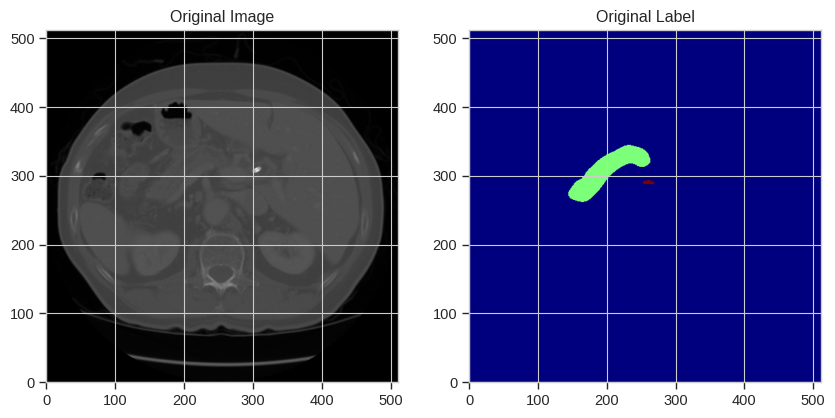

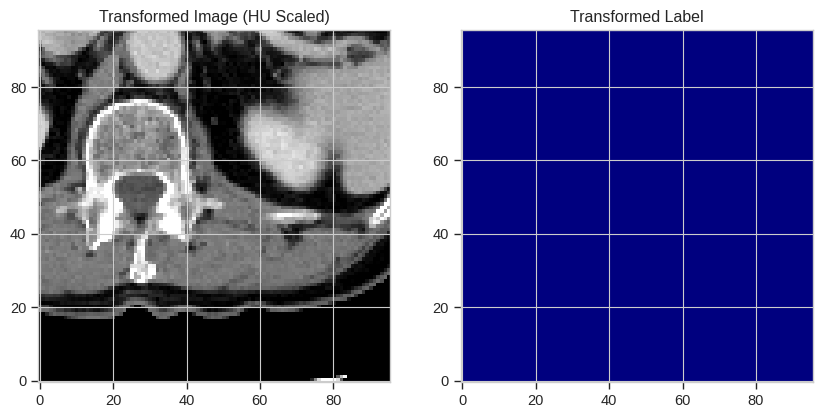

In [13]:
# plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(base_data["image"][0, :, :, base_data["image"].shape[3]//2].T, cmap="gray", origin="lower")
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(base_data["label"][0, :, :, base_data["label"].shape[3]//2].T, cmap="jet", origin="lower")
plt.title("Original Label")
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(check_data["image"][0, :, :, check_data["image"].shape[3]//2].T, cmap="gray", origin="lower")
plt.title("Transformed Image (HU Scaled)")
plt.subplot(1, 2, 2)
plt.imshow(check_data["label"][0, :, :, check_data["label"].shape[3]//2].T, cmap="jet", origin="lower")
plt.title("Transformed Label")
plt.show()

sanity check complete


## Sanity check for model-data connection

see [unet model code](src/models/unet.py)

In [14]:
# Device Check (mps for mac)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")
print(f"Using device: {device}")

model = get_unet_model(device)

input_tensor = check_data["image"].unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_tensor)

print(f"Input Shape: {input_tensor.shape}")
print(f"Output Shape: {output.shape}")

Using device: cuda
Input Shape: torch.Size([1, 1, 96, 96, 96])
Output Shape: torch.Size([1, 2, 96, 96, 96])


# Training

## Step by step ... : training 1 epoch

see [training code](src/training/train.py)

In [15]:
# 1. loss function - using dice loss due to analysis (high class imbalance!)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
print(f"Label Unique Values: {torch.unique(check_data['label'])}")
print(f"Label Shape: {check_data['label'].shape}")

# 2. simple adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 3. training
print("Starting initial test training...")
loss = train_one_epoch(model, [check_data], optimizer, loss_function, device)
print(f"Test Loss: {loss:.4f}")

Label Unique Values: tensor([0.])
Label Shape: torch.Size([1, 96, 96, 96])
Starting initial test training...
Test Loss: 0.6879


## full Training

In [16]:
# device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")
print(f"Using device: {device}")

Using device: cuda


In [17]:
def check_gpu_status(model=None):

    if torch.cuda.is_available():
        device_name = torch.cuda.get_device_name(0)
        print(f"GPU Available: {device_name}")

        free_mem, total_mem = torch.cuda.mem_get_info()
        print(f"   Memory: {free_mem/1024**3:.2f} GB free / {total_mem/1024**3:.2f} GB total")

        if model:
            param_device = next(model.parameters()).device
            if param_device.type == 'cuda':
                print(f"Model is explicitly on GPU ({param_device})")
            else:
                print(f"WARNING: Model is on {param_device}, NOT on GPU!")
    else:
        print("NO GPU DETECTED! Training will be slow.")

check_gpu_status(model)

GPU Available: NVIDIA A100-SXM4-80GB
   Memory: 78.50 GB free / 79.32 GB total
Model is explicitly on GPU (cuda:0)


In [18]:
try:
    print("\n[1] Nvidia-SMI Output:")
    result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,utilization.gpu', '--format=csv,noheader'], stdout=subprocess.PIPE, text=True)
    print(result.stdout)
except:
    print("nvidia-smi failed ")


if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print(f"\n[2] PyTorch uses: {torch.cuda.get_device_name(current_device)}")

    param_device = next(model.parameters()).device
    print(f"\n[3] model params at: {param_device}")

    if param_device.type == 'cuda':
        print("\ngpu working")
    else:
        print("\nmodel on cpu!!")
else:
    print("\nno gpu found")


[1] Nvidia-SMI Output:
NVIDIA A100-SXM4-80GB, 81920 MiB, 6 %


[2] PyTorch uses: NVIDIA A100-SXM4-80GB

[3] model params at: cuda:0

gpu working


In [19]:
# config
# data_dir = os.path.join(root_dir, "data", "raw", "Task07_Pancreas" , "imagesTr")
# label_dir = os.path.join(root_dir, "data", "raw", "Task07_Pancreas" , "labelsTr")
# model_dir = os.path.join(root_dir, "models")
#data_dir = "/content/drive/MyDrive/other/ct-segmentation-monai/data/raw/Task07_Pancreas/imagesTr"
#label_dir = "/content/drive/MyDrive/other/ct-segmentation-monai/data/raw/Task07_Pancreas/labelsTr"
model_dir = "/content/drive/MyDrive/other/ct-segmentation-monai/models"

data_dir = os.path.join(local_dir, "imagesTr")
label_dir = os.path.join(local_dir, "labelsTr")
os.makedirs(model_dir, exist_ok=True)



In [20]:
# data
#images = sorted(glob.glob(os.path.join(data_dir, "*.nii.gz")))
#labels = sorted(glob.glob(os.path.join(label_dir, "*.nii.gz")))
images = sorted(glob.glob(os.path.join(data_dir, "*.nii.gz")))
labels = sorted(glob.glob(os.path.join(label_dir, "*.nii.gz")))
print(f"Found {len(images)} images and {len(labels)} labels")

data_dicts = [{"image": img, "label": lbl} for img, lbl in zip(images, labels)]

train_files = data_dicts[:-70]
val_files = data_dicts[-70:-10]
test_files = data_dicts[-10:]

train_ds = CacheDataset(data=train_files, transform=get_train_transforms(), cache_rate=1.0, num_workers=4)
#train_ds = Dataset(data=train_files, transform=get_train_transforms()
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)

val_ds = CacheDataset(data=val_files,  transform=get_val_transforms(), cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2, pin_memory=True)

test_ds = CacheDataset(data=test_files,  transform=get_val_transforms(), cache_rate=1.0, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=2, pin_memory=True)

print(f"Total training samples: {len(train_files)}")
print(f"Total validation samples: {len(val_files)}")
print(f"Total test samples: {len(test_files)}")

/usr/local/lib/python3.12/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


Found 281 images and 281 labels


Loading dataset: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]

Total training samples: 211
Total validation samples: 60
Total test samples: 10


In [21]:
check_img_path = images[0]
check_lbl_path = labels[0]

print(f"Checking Image: {check_img_path}")
print(f"Checking Label: {check_lbl_path}")

lbl_obj = nib.load(check_lbl_path)
lbl_data = lbl_obj.get_fdata()

print(f"Label Shape: {lbl_data.shape}")
print(f"Label Unique Values (Min/Max): {np.min(lbl_data)} / {np.max(lbl_data)}")
print(f"Unique Values (Sample): {np.unique(lbl_data)[:20]}")

Checking Image: /content/data/Task07_Pancreas/imagesTr/pancreas_001.nii.gz
Checking Label: /content/data/Task07_Pancreas/labelsTr/pancreas_001.nii.gz
Label Shape: (512, 512, 110)
Label Unique Values (Min/Max): 0.0 / 2.0
Unique Values (Sample): [0. 1. 2.]


metatensor([0., 1.])
Image Shape: torch.Size([4, 1, 96, 96, 96])
Label Shape: torch.Size([4, 1, 96, 96, 96])
Label Unique Values: tensor([0., 1.])


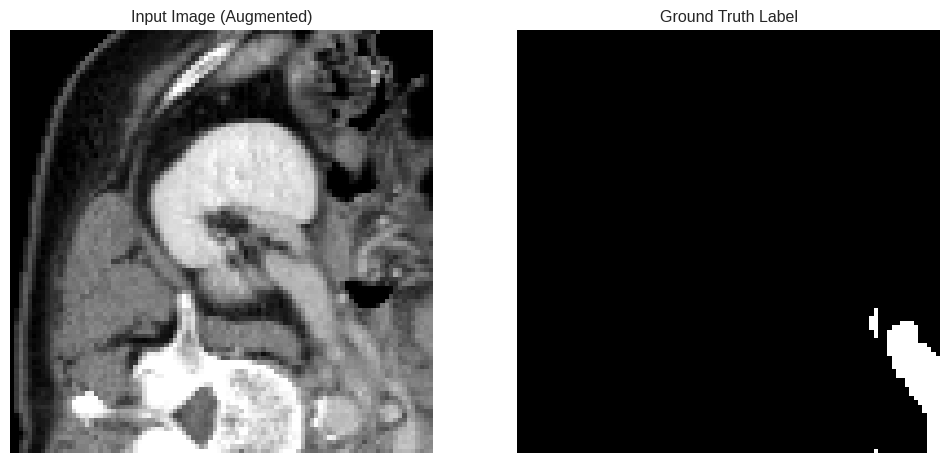

In [ ]:
# 1. batch
batch = next(iter(train_loader))
images = batch["image"]
labels = batch["labels"] if "labels" in batch else batch["label"]
print(torch.unique(labels))

print(f"Image Shape: {images.shape}") # Sollte (B, 1, 96, 96, 96) sein
print(f"Label Shape: {labels.shape}") # Sollte (B, 1, 96, 96, 96) sein
print(f"Label Unique Values: {torch.unique(labels)}") # MUSS [0., 1.] sein (oder 0, 1, 2)

# 2. visualization
slice_idx = 48
plt.figure(figsize=(12, 6))

# original 
plt.subplot(1, 2, 1)
plt.title("Input Image (Augmented)")
plt.imshow(images[0, 0, :, :, slice_idx].detach().cpu(), cmap="gray")
plt.axis("off")

# Label 
plt.subplot(1, 2, 2)
plt.title("Ground Truth Label")
plt.imshow(labels[0, 0, :, :, slice_idx].detach().cpu(), cmap="gray", vmin=0, vmax=1)
plt.axis("off")

plt.show()

In [23]:
learning_rate = 1e-4

In [24]:
# Model
model = get_unet_model(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
dice_metric = DiceMetric(include_background=False, reduction="mean_batch")

In [26]:
# Setup
num_epochs = 150
val_interval = 1
best_metric = -1
best_metric_epoch = -1
train_losses = []
val_metrics = []


model_filename = os.path.join(model_dir, "best_unet_model.pth")

print(f"\n--- Starting Full Training Loop ({num_epochs} Epochs) ---")

total_start = time.time()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # timer start
    epoch_start = time.time()

    # Training
    epoch_loss = train_one_epoch(model, train_loader, optimizer, loss_function, device)
    train_losses.append(epoch_loss)

    # timer end
    epoch_end = time.time()
    epoch_duration = epoch_end - epoch_start
    duration_str = str(datetime.timedelta(seconds=int(epoch_duration)))

    print(f"Training Loss: {epoch_loss:.4f} | Time: {duration_str}")

    # Validation
    if (epoch + 1) % val_interval == 0:
        val_dice = validate_one_epoch(model, val_loader, dice_metric, device)
        val_metrics.append(val_dice)
        print(f"Validation Dice: {val_dice:.4f}")

        if val_dice >= best_metric:
            best_metric = val_dice
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), model_filename)
            print(f"--> Saved new best model (Dice: {best_metric:.4f})")

    # save model every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, f"model_epoch_{epoch+1}.pth"))


total_time = str(datetime.timedelta(seconds=int(time.time() - total_start)))
print(f"\n--- Training Finished in {total_time} ---")
print(f"Best validation Dice metric: {best_metric:.4f} at epoch {best_metric_epoch}")


--- Starting Full Training Loop (150 Epochs) ---

Epoch 1/150
Training Loss: 0.6235 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.75batch/s]

Validation Dice: 0.0216
--> Saved new best model (Dice: 0.0216)

Epoch 2/150


Training Loss: 0.6059 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.83batch/s]

Validation Dice: 0.0237
--> Saved new best model (Dice: 0.0237)

Epoch 3/150


Training Loss: 0.5924 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.90batch/s]

Validation Dice: 0.0273
--> Saved new best model (Dice: 0.0273)

Epoch 4/150


Training Loss: 0.5834 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.75batch/s]

Validation Dice: 0.0307
--> Saved new best model (Dice: 0.0307)

Epoch 5/150


Training Loss: 0.5723 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.79batch/s]

Validation Dice: 0.0387
--> Saved new best model (Dice: 0.0387)

Epoch 6/150


Training Loss: 0.5620 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.86batch/s]

Validation Dice: 0.0361

Epoch 7/150


Training Loss: 0.5551 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.77batch/s]

Validation Dice: 0.0565
--> Saved new best model (Dice: 0.0565)

Epoch 8/150


Training Loss: 0.5452 | Time: 0:00:14


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.74batch/s]

Validation Dice: 0.0458

Epoch 9/150


Training Loss: 0.5356 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.75batch/s]

Validation Dice: 0.0713
--> Saved new best model (Dice: 0.0713)

Epoch 10/150


Training Loss: 0.5280 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.74batch/s]

Validation Dice: 0.0946
--> Saved new best model (Dice: 0.0946)

Epoch 11/150


Training Loss: 0.5174 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.77batch/s]

Validation Dice: 0.1137
--> Saved new best model (Dice: 0.1137)

Epoch 12/150


Training Loss: 0.5107 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.83batch/s]

Validation Dice: 0.0575

Epoch 13/150


Training Loss: 0.5029 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.84batch/s]

Validation Dice: 0.0432

Epoch 14/150


Training Loss: 0.5013 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.78batch/s]

Validation Dice: 0.0578

Epoch 15/150


Training Loss: 0.4893 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.74batch/s]

Validation Dice: 0.0422

Epoch 16/150


Training Loss: 0.4798 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.78batch/s]

Validation Dice: 0.0707

Epoch 17/150


Training Loss: 0.4674 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.78batch/s]

Validation Dice: 0.0672

Epoch 18/150


Training Loss: 0.4619 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.79batch/s]

Validation Dice: 0.0509

Epoch 19/150


Training Loss: 0.4579 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.81batch/s]

Validation Dice: 0.1006

Epoch 20/150


Training Loss: 0.4445 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.81batch/s]

Validation Dice: 0.0669

Epoch 21/150


Training Loss: 0.4278 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.73batch/s]

Validation Dice: 0.0390

Epoch 22/150


Training Loss: 0.4238 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.81batch/s]

Validation Dice: 0.0249

Epoch 23/150


Training Loss: 0.4254 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.76batch/s]

Validation Dice: 0.0210

Epoch 24/150


Training Loss: 0.4105 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.82batch/s]

Validation Dice: 0.1855
--> Saved new best model (Dice: 0.1855)

Epoch 25/150


Training Loss: 0.4054 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.83batch/s]

Validation Dice: 0.1125

Epoch 26/150


Training Loss: 0.4079 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.77batch/s]

Validation Dice: 0.1626

Epoch 27/150


Training Loss: 0.3800 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.82batch/s]

Validation Dice: 0.0843

Epoch 28/150


Training Loss: 0.3724 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.82batch/s]

Validation Dice: 0.1435

Epoch 29/150


Training Loss: 0.3730 | Time: 0:00:14


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.84batch/s]

Validation Dice: 0.1086

Epoch 30/150


Training Loss: 0.3605 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.76batch/s]

Validation Dice: 0.4210
--> Saved new best model (Dice: 0.4210)

Epoch 31/150


Training Loss: 0.3571 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.80batch/s]

Validation Dice: 0.3625

Epoch 32/150


Training Loss: 0.3586 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.83batch/s]

Validation Dice: 0.1387

Epoch 33/150


Training Loss: 0.3581 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.83batch/s]

Validation Dice: 0.3426

Epoch 34/150


Training Loss: 0.3453 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.85batch/s]

Validation Dice: 0.4191

Epoch 35/150


Training Loss: 0.3383 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.80batch/s]

Validation Dice: 0.3800

Epoch 36/150


Training Loss: 0.3533 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.90batch/s]

Validation Dice: 0.3999

Epoch 37/150


Training Loss: 0.3382 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.82batch/s]

Validation Dice: 0.3512

Epoch 38/150


Training Loss: 0.3486 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:13<00:00,  4.38batch/s]

Validation Dice: 0.1890

Epoch 39/150


Training Loss: 0.3361 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.79batch/s]

Validation Dice: 0.4652
--> Saved new best model (Dice: 0.4652)

Epoch 40/150


Training Loss: 0.3289 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.87batch/s]

Validation Dice: 0.4498

Epoch 41/150


Training Loss: 0.3295 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.82batch/s]

Validation Dice: 0.4968
--> Saved new best model (Dice: 0.4968)

Epoch 42/150


Training Loss: 0.3085 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.85batch/s]

Validation Dice: 0.4777

Epoch 43/150


Training Loss: 0.3180 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.87batch/s]

Validation Dice: 0.5041
--> Saved new best model (Dice: 0.5041)

Epoch 44/150


Training Loss: 0.3144 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.87batch/s]

Validation Dice: 0.4521

Epoch 45/150


Training Loss: 0.3323 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.85batch/s]

Validation Dice: 0.4528

Epoch 46/150


Training Loss: 0.3161 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.88batch/s]

Validation Dice: 0.3682

Epoch 47/150


Training Loss: 0.3187 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.62batch/s]

Validation Dice: 0.5046
--> Saved new best model (Dice: 0.5046)

Epoch 48/150


Training Loss: 0.3287 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.77batch/s]

Validation Dice: 0.4989

Epoch 49/150


Training Loss: 0.3204 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.86batch/s]

Validation Dice: 0.4559

Epoch 50/150


Training Loss: 0.3251 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.84batch/s]

Validation Dice: 0.5249
--> Saved new best model (Dice: 0.5249)

Epoch 51/150


Training Loss: 0.3029 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.77batch/s]

Validation Dice: 0.5147

Epoch 52/150


Training Loss: 0.3231 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.86batch/s]

Validation Dice: 0.4817

Epoch 53/150


Training Loss: 0.3010 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.87batch/s]

Validation Dice: 0.5046

Epoch 54/150


Training Loss: 0.3073 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.81batch/s]

Validation Dice: 0.5141

Epoch 55/150


Training Loss: 0.3129 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.89batch/s]

Validation Dice: 0.4979

Epoch 56/150


Training Loss: 0.3135 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:13<00:00,  4.47batch/s]

Validation Dice: 0.5557
--> Saved new best model (Dice: 0.5557)

Epoch 57/150


Training Loss: 0.3203 | Time: 0:00:14


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.90batch/s]

Validation Dice: 0.4971

Epoch 58/150


Training Loss: 0.3001 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.81batch/s]

Validation Dice: 0.5552

Epoch 59/150


Training Loss: 0.2994 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.89batch/s]

Validation Dice: 0.5400

Epoch 60/150


Training Loss: 0.2776 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.89batch/s]

Validation Dice: 0.5552

Epoch 61/150


Training Loss: 0.2810 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.91batch/s]

Validation Dice: 0.5290

Epoch 62/150


Training Loss: 0.3009 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.75batch/s]

Validation Dice: 0.5115

Epoch 63/150


Training Loss: 0.3015 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.80batch/s]

Validation Dice: 0.5428

Epoch 64/150


Training Loss: 0.2989 | Time: 0:00:14


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.79batch/s]

Validation Dice: 0.5129

Epoch 65/150


Training Loss: 0.2896 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.73batch/s]

Validation Dice: 0.5739
--> Saved new best model (Dice: 0.5739)

Epoch 66/150


Training Loss: 0.2914 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.81batch/s]

Validation Dice: 0.5563

Epoch 67/150


Training Loss: 0.2899 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.83batch/s]

Validation Dice: 0.5646

Epoch 68/150


Training Loss: 0.2921 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.78batch/s]

Validation Dice: 0.5774
--> Saved new best model (Dice: 0.5774)

Epoch 69/150


Training Loss: 0.2928 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.81batch/s]

Validation Dice: 0.5141

Epoch 70/150


Training Loss: 0.2965 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.79batch/s]

Validation Dice: 0.5746

Epoch 71/150


Training Loss: 0.3101 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.79batch/s]

Validation Dice: 0.5169

Epoch 72/150


Training Loss: 0.2988 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.75batch/s]

Validation Dice: 0.5412

Epoch 73/150


Training Loss: 0.3018 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.78batch/s]

Validation Dice: 0.5211

Epoch 74/150


Training Loss: 0.3028 | Time: 0:00:14


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.76batch/s]

Validation Dice: 0.5869
--> Saved new best model (Dice: 0.5869)

Epoch 75/150


Training Loss: 0.3014 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.79batch/s]

Validation Dice: 0.5499

Epoch 76/150


Training Loss: 0.2950 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.81batch/s]

Validation Dice: 0.5920
--> Saved new best model (Dice: 0.5920)

Epoch 77/150


Training Loss: 0.2788 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.85batch/s]

Validation Dice: 0.5867

Epoch 78/150


Training Loss: 0.2805 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.89batch/s]

Validation Dice: 0.5609

Epoch 79/150


Training Loss: 0.2764 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.85batch/s]

Validation Dice: 0.6065
--> Saved new best model (Dice: 0.6065)

Epoch 80/150


Training Loss: 0.2991 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.81batch/s]

Validation Dice: 0.5660

Epoch 81/150


Training Loss: 0.2969 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.83batch/s]

Validation Dice: 0.5738

Epoch 82/150


Training Loss: 0.2836 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.80batch/s]

Validation Dice: 0.5645

Epoch 83/150


Training Loss: 0.2882 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.62batch/s]

Validation Dice: 0.4853

Epoch 84/150


Training Loss: 0.2777 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.82batch/s]

Validation Dice: 0.5605

Epoch 85/150


Training Loss: 0.2866 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.85batch/s]

Validation Dice: 0.5840

Epoch 86/150


Training Loss: 0.2866 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.86batch/s]

Validation Dice: 0.5895

Epoch 87/150


Training Loss: 0.2870 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.78batch/s]

Validation Dice: 0.5575

Epoch 88/150


Training Loss: 0.2745 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.82batch/s]

Validation Dice: 0.5945

Epoch 89/150


Training Loss: 0.2784 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.82batch/s]

Validation Dice: 0.5837

Epoch 90/150


Training Loss: 0.2934 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.88batch/s]

Validation Dice: 0.5979

Epoch 91/150


Training Loss: 0.2727 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.89batch/s]

Validation Dice: 0.5983

Epoch 92/150


Training Loss: 0.2888 | Time: 0:00:14


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.89batch/s]

Validation Dice: 0.5227

Epoch 93/150


Training Loss: 0.2992 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.86batch/s]

Validation Dice: 0.5745

Epoch 94/150


Training Loss: 0.2816 | Time: 0:00:11


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.88batch/s]

Validation Dice: 0.5915

Epoch 95/150


Training Loss: 0.2736 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.85batch/s]

Validation Dice: 0.6003

Epoch 96/150


Training Loss: 0.2572 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.81batch/s]

Validation Dice: 0.6041

Epoch 97/150


Training Loss: 0.2690 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.87batch/s]

Validation Dice: 0.5980

Epoch 98/150


Training Loss: 0.2778 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.93batch/s]

Validation Dice: 0.6286
--> Saved new best model (Dice: 0.6286)

Epoch 99/150


Training Loss: 0.2749 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.85batch/s]

Validation Dice: 0.6151

Epoch 100/150


Training Loss: 0.2656 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.87batch/s]

Validation Dice: 0.5403

Epoch 101/150


Training Loss: 0.2887 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:13<00:00,  4.55batch/s]

Validation Dice: 0.6303
--> Saved new best model (Dice: 0.6303)

Epoch 102/150


Training Loss: 0.2876 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.86batch/s]

Validation Dice: 0.5828

Epoch 103/150


Training Loss: 0.2780 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.83batch/s]

Validation Dice: 0.5701

Epoch 104/150


Training Loss: 0.3074 | Time: 0:00:14


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.87batch/s]

Validation Dice: 0.5894

Epoch 105/150


Training Loss: 0.2797 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.80batch/s]

Validation Dice: 0.6164

Epoch 106/150


Training Loss: 0.2456 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.83batch/s]

Validation Dice: 0.5807

Epoch 107/150


Training Loss: 0.2606 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.85batch/s]

Validation Dice: 0.5718

Epoch 108/150


Training Loss: 0.2593 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.91batch/s]

Validation Dice: 0.6221

Epoch 109/150


Training Loss: 0.2789 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.86batch/s]

Validation Dice: 0.5749

Epoch 110/150


Training Loss: 0.2645 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.69batch/s]

Validation Dice: 0.6182

Epoch 111/150


Training Loss: 0.2731 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.85batch/s]

Validation Dice: 0.5711

Epoch 112/150


Training Loss: 0.2565 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.86batch/s]

Validation Dice: 0.6106

Epoch 113/150


Training Loss: 0.2640 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.86batch/s]

Validation Dice: 0.6130

Epoch 114/150


Training Loss: 0.2715 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.87batch/s]

Validation Dice: 0.6120

Epoch 115/150


Training Loss: 0.2788 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.82batch/s]

Validation Dice: 0.5914

Epoch 116/150


Training Loss: 0.2844 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.86batch/s]

Validation Dice: 0.6032

Epoch 117/150


Training Loss: 0.2577 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.82batch/s]

Validation Dice: 0.6164

Epoch 118/150


Training Loss: 0.2635 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.83batch/s]

Validation Dice: 0.6411
--> Saved new best model (Dice: 0.6411)

Epoch 119/150


Training Loss: 0.2554 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:13<00:00,  4.59batch/s]

Validation Dice: 0.6118

Epoch 120/150


Training Loss: 0.2828 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.90batch/s]

Validation Dice: 0.5385

Epoch 121/150


Training Loss: 0.2748 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.86batch/s]

Validation Dice: 0.5828

Epoch 122/150


Training Loss: 0.2589 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.82batch/s]

Validation Dice: 0.5940

Epoch 123/150


Training Loss: 0.2647 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.87batch/s]

Validation Dice: 0.5832

Epoch 124/150


Training Loss: 0.2678 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.82batch/s]

Validation Dice: 0.5956

Epoch 125/150


Training Loss: 0.2620 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.80batch/s]

Validation Dice: 0.6027

Epoch 126/150


Training Loss: 0.2821 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.74batch/s]

Validation Dice: 0.5598

Epoch 127/150


Training Loss: 0.2743 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.73batch/s]

Validation Dice: 0.6413
--> Saved new best model (Dice: 0.6413)

Epoch 128/150


Training Loss: 0.2664 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:13<00:00,  4.56batch/s]

Validation Dice: 0.6261

Epoch 129/150


Training Loss: 0.2572 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.78batch/s]

Validation Dice: 0.6085

Epoch 130/150


Training Loss: 0.2491 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.78batch/s]

Validation Dice: 0.6151

Epoch 131/150


Training Loss: 0.2571 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.84batch/s]

Validation Dice: 0.6115

Epoch 132/150


Training Loss: 0.2676 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.82batch/s]

Validation Dice: 0.5837

Epoch 133/150


Training Loss: 0.2727 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.77batch/s]

Validation Dice: 0.6352

Epoch 134/150


Training Loss: 0.2594 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.79batch/s]

Validation Dice: 0.6518
--> Saved new best model (Dice: 0.6518)

Epoch 135/150


Training Loss: 0.2662 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.74batch/s]

Validation Dice: 0.6414

Epoch 136/150


Training Loss: 0.2698 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.80batch/s]

Validation Dice: 0.6536
--> Saved new best model (Dice: 0.6536)

Epoch 137/150


Training Loss: 0.2614 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:13<00:00,  4.57batch/s]

Validation Dice: 0.6488

Epoch 138/150


Training Loss: 0.2644 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.85batch/s]

Validation Dice: 0.6201

Epoch 139/150


Training Loss: 0.2634 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.83batch/s]

Validation Dice: 0.5918

Epoch 140/150


Training Loss: 0.2633 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.77batch/s]

Validation Dice: 0.5902

Epoch 141/150


Training Loss: 0.2621 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.77batch/s]

Validation Dice: 0.6230

Epoch 142/150


Training Loss: 0.2430 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.81batch/s]

Validation Dice: 0.6172

Epoch 143/150


Training Loss: 0.2611 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.77batch/s]

Validation Dice: 0.6414

Epoch 144/150


Training Loss: 0.2585 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.79batch/s]

Validation Dice: 0.6401

Epoch 145/150


Training Loss: 0.2574 | Time: 0:00:13


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.83batch/s]

Validation Dice: 0.6408

Epoch 146/150


Training Loss: 0.2521 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.82batch/s]

Validation Dice: 0.6377

Epoch 147/150


Training Loss: 0.2721 | Time: 0:00:14


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.82batch/s]

Validation Dice: 0.5797

Epoch 148/150


Training Loss: 0.2505 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.80batch/s]

Validation Dice: 0.6576
--> Saved new best model (Dice: 0.6576)

Epoch 149/150


Training Loss: 0.2740 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.82batch/s]

Validation Dice: 0.6506

Epoch 150/150


Training Loss: 0.2635 | Time: 0:00:12


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.85batch/s]

Validation Dice: 0.6442

--- Training Finished in 1:03:45 ---
Best validation Dice metric: 0.6576 at epoch 148



Plotting training history...


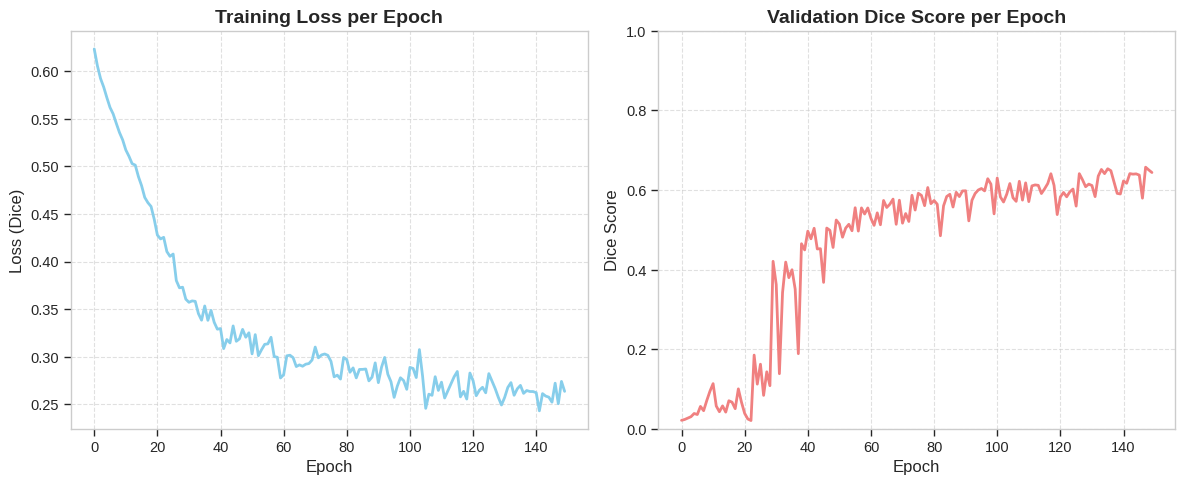

In [27]:
# train history
print("\nPlotting training history...")
plot_loss_metrics(train_losses, val_metrics, save_path=os.path.join(root_dir, "ct-segmentation-monai", "results", "train_val_history.png"))

In [28]:
# eval
print("\n--- Starting Evaluation on Test Set ---")
model.load_state_dict(torch.load(model_filename))
test_dice = validate_one_epoch(model, test_loader, dice_metric, device)
print(f"Final Test Dice Score: {test_dice:.4f}")


--- Starting Evaluation on Test Set ---


Validation: 100%|██████████| 10/10 [00:03<00:00,  2.73batch/s]

Final Test Dice Score: 0.6321



Plotting example predictions from test set...


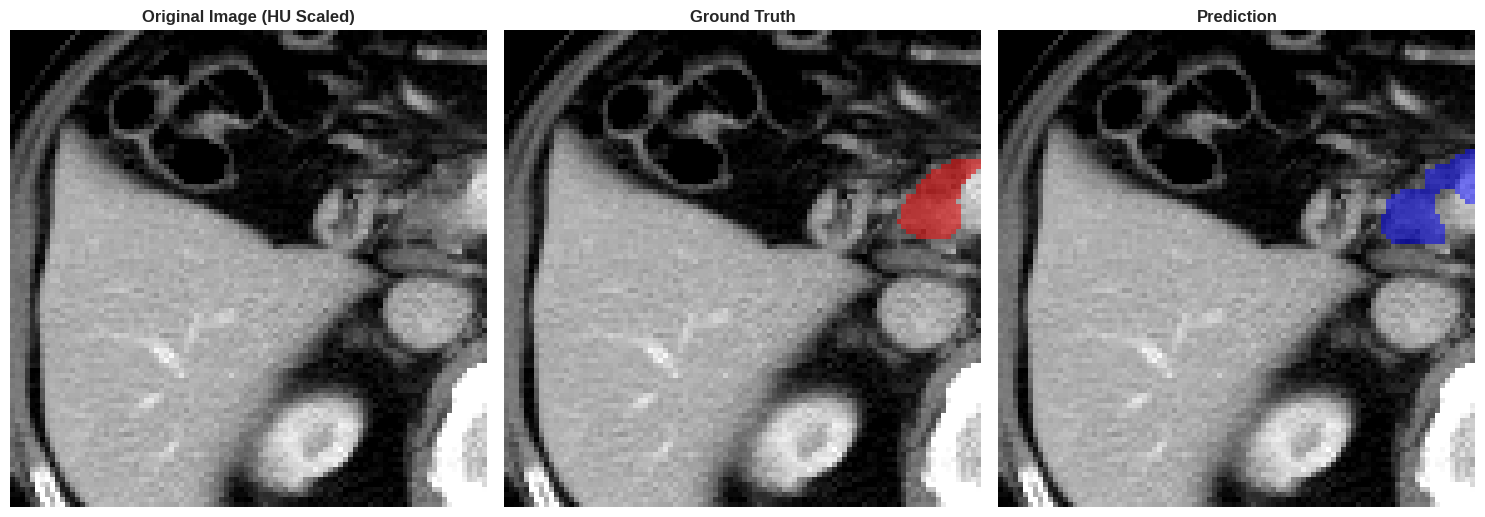

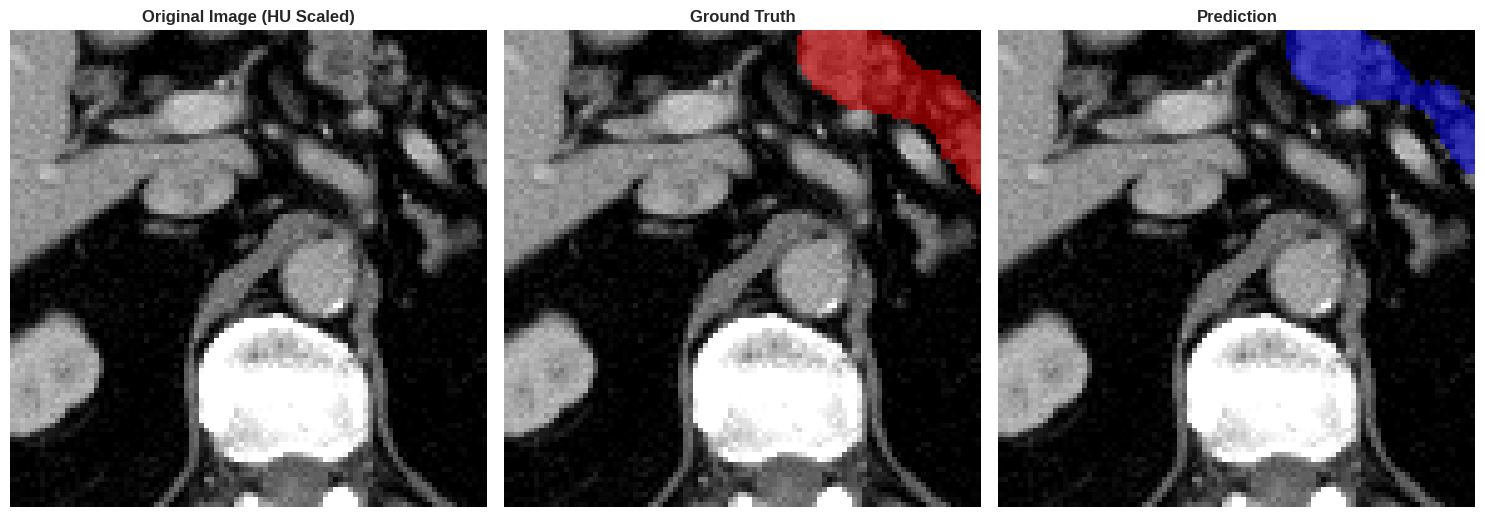

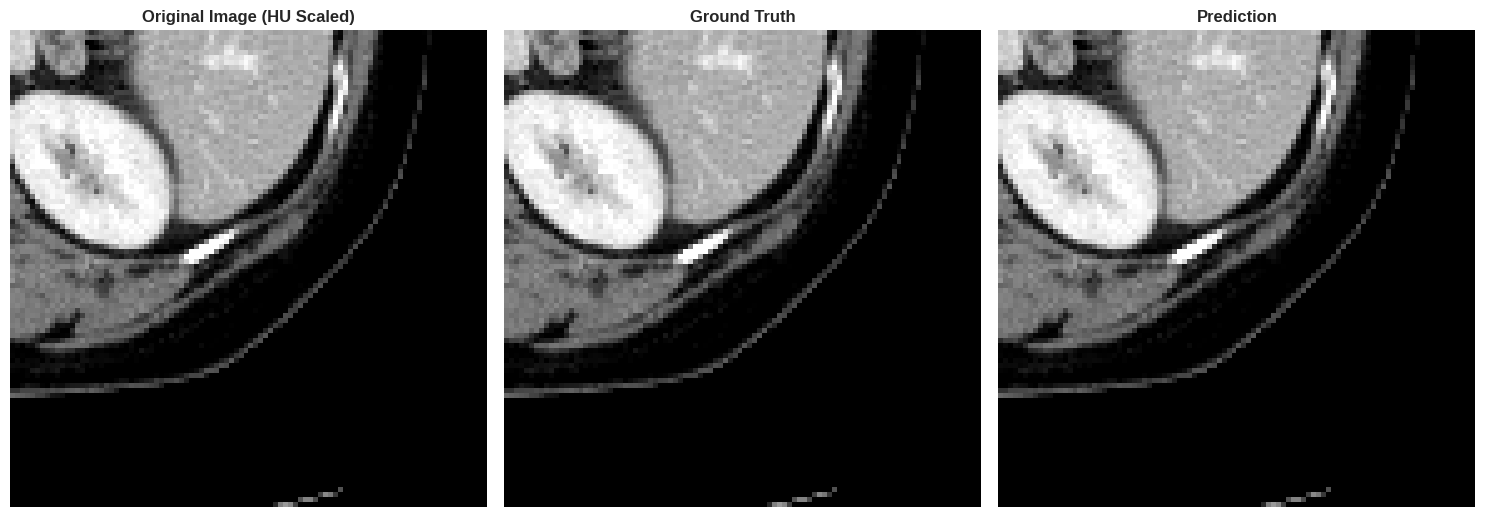

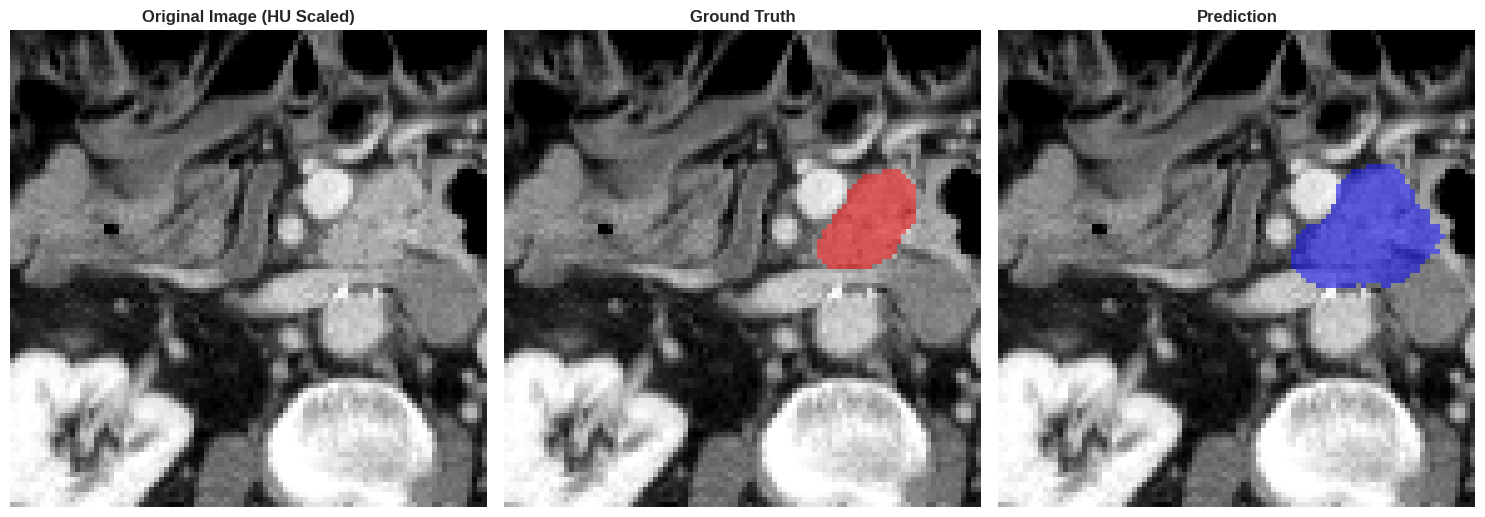

In [29]:
# pred
print("\nPlotting example predictions from test set...")
model.eval()
with torch.no_grad():
    for i, test_data_sample in enumerate(train_loader):
        if i >= 4:
            break

        inputs, labels = test_data_sample["image"].to(device), test_data_sample["label"].to(device)

        if inputs.dim() == 4:
            inputs = inputs.unsqueeze(0)
        if labels.dim() == 4:
            labels = labels.unsqueeze(0)

        outputs = model(inputs)
        predicted_mask = torch.argmax(outputs, dim=1).unsqueeze(1)


        plot_segmentation_predictions(
            image=inputs[0].cpu(),
            ground_truth=labels[0].cpu(),
            prediction=predicted_mask[0].cpu(),
            save_path=os.path.join(root_dir, "ct-segmentation-monai", "results", f"prediction_sample_{i+1}.png")
        )
